In [50]:

import pandas as pd
pd.set_option("max_colwidth", None)
import pandas as pd
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
import torch
from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet, NaNLabelEncoder
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, QuantileLoss, MAPE
import locale
import pickle
locale.setlocale(locale.LC_ALL, 'it_IT')


'it_IT'

In [51]:
df_settimanale = pd.read_csv("processed_data/first_dataset.csv")
df_settimanale["time_idx"] = df_settimanale["time_idx"].astype(int)
df_settimanale["azoto_oraria_max"] = df_settimanale["azoto_oraria_max"].astype(float)
df_settimanale["zolfo_giornaliera"] = df_settimanale["zolfo_giornaliera"].astype(float)
df_settimanale["ozono_8h_max"] = df_settimanale["ozono_8h_max"].astype(float)
df_settimanale["pm2dot5_giornaliera"] = df_settimanale["pm2dot5_giornaliera"].astype(float)
df_settimanale["pm10_giornaliera"] = df_settimanale["pm10_giornaliera"].astype(float)
df_settimanale["provincia"] = df_settimanale["provincia"].astype(str)


In [52]:
df_settimanale=df_settimanale.drop(["Unnamed: 0"], axis=1)
df_settimanale

,provincia,time_idx,azoto_oraria_max,zolfo_giornaliera,ozono_8h_max,pm2dot5_giornaliera,pm10_giornaliera,relative_time_w,relative_time_y,relative_time_m
0,Gorizia,0,28.006272,3.661250,53.649062,16.647083,18.015583,1.0,2014.0,5.125000
1,Gorizia,1,45.018673,5.331905,13.312857,40.959762,49.991549,2.0,2014.0,1.000000
2,Gorizia,2,45.632117,4.936048,40.546714,22.282857,29.161928,3.0,2014.0,1.000000
3,Gorizia,3,44.446463,5.484762,32.052524,14.080952,17.742073,4.0,2014.0,1.000000
4,Gorizia,4,30.148980,4.187143,57.219524,14.944286,17.136072,5.0,2014.0,1.285714
...,...,...,...,...,...,...,...,...,...,...
1431,Udine,354,32.206987,3.108571,64.327466,29.528571,32.824346,43.0,2020.0,10.000000
1432,Udine,355,35.572812,2.835714,49.331905,16.853571,19.789032,44.0,2020.0,10.142857
1433,Udine,356,39.426567,1.990000,43.992847,20.578049,24.522095,45.0,2020.0,11.000000
1434,Udine,357,41.356416,2.164286,43.834728,22.157143,22.998696,46.0,2020.0,11.000000


In [53]:
max_prediction_length = 4
max_encoder_length = 16
training_cutoff = df_settimanale["time_idx"].max() - max_prediction_length

training = TimeSeriesDataSet(
    df_settimanale[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="pm10_giornaliera",
    group_ids=["provincia"],
    min_encoder_length=max_encoder_length, 
    max_encoder_length=max_encoder_length,
    min_prediction_length=max_prediction_length,
    max_prediction_length=max_prediction_length,
    static_categoricals=["provincia"],
    time_varying_known_reals=["time_idx","relative_time_w","relative_time_y","relative_time_m"],
    time_varying_unknown_reals=[
        "azoto_oraria_max","zolfo_giornaliera",
        "ozono_8h_max","pm2dot5_giornaliera","pm10_giornaliera"
    ],
    target_normalizer=GroupNormalizer(
        groups=["provincia"], transformation="relu", scale_by_group=True
    ),
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)

In [54]:
validation = TimeSeriesDataSet.from_dataset(training, df_settimanale, predict=True, stop_randomization=True)

batch_size = 64
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=0)

Calcolo delle performance della baseline, utili per verificare i risultati dell'algoritmo

In [55]:
from sklearn.metrics import mean_absolute_percentage_error

actuals = torch.cat([y for x, (y, weight) in iter(val_dataloader)])
baseline_model = Baseline()
baseline_predictions = baseline_model.predict(val_dataloader)
maPe = mean_absolute_percentage_error(actuals.sum(1), baseline_predictions.sum(1))
maPe

0.31406358

## Training

In [56]:
# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=15, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate

trainer = pl.Trainer(
    max_epochs=100,
    gpus=0,
    weights_summary="top",
    gradient_clip_val=0.2,
    callbacks=[lr_logger],
)

tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.015,
    hidden_size=16,  # most important hyperparameter apart from learning rate
    attention_head_size=2,# number of attention heads. Set to up to 4 for large datasets
    dropout=0.2,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=8,  # set to <= hidden_size
    output_size=7,  
    loss=QuantileLoss(),
    reduce_on_plateau_patience=50,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Number of parameters in network: 25.4k


In [57]:
# fit network
tft.learning_rate=0.05
trainer.fit(
    tft,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
    
)

C:\RoboDK\Python37\lib\site-packages\pytorch_lightning\trainer\trainer.py:733: LightningDeprecationWarning: `trainer.fit(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.fit(train_dataloaders)` instead. HINT: added 's'
  "`trainer.fit(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6."

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 12    
3  | prescalers                         | ModuleDict                      | 208   
4  | static_variable_selection          | VariableSelectionNetwork        | 1.8 K 
5  | encoder_variable_selection         | VariableSelectionNetwork      

C:\RoboDK\Python37\lib\site-packages\pytorch_lightning\trainer\data_loading.py:117: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
C:\RoboDK\Python37\lib\site-packages\pytorch_lightning\trainer\data_loading.py:117: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
C:\RoboDK\Python37\lib\site-packages\pytorch_lightning\trainer\data_loading.py:413: UserWarning: The number of training samples (21) is smal

Epoch 99: 100%|██████████| 22/22 [00:04<00:00,  5.46it/s, loss=0.875, v_num=0, train_loss_step=0.966, val_loss=3.310, train_loss_epoch=0.881]


## Valutazione del modello

In [58]:
# load the best model according to the validation loss
# (given that we use early stopping, this is not necessarily the last epoch)
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

In [59]:
# calcualte mean absolute error on validation set
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_tft.predict(val_dataloader)

maPe = mean_absolute_percentage_error(actuals.sum(1), predictions.sum(1))
maPe

0.29297045

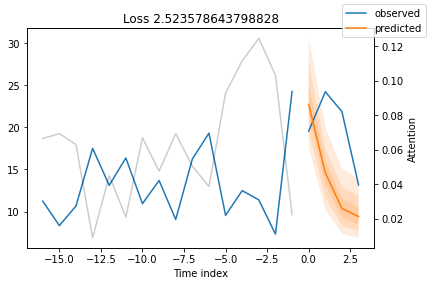

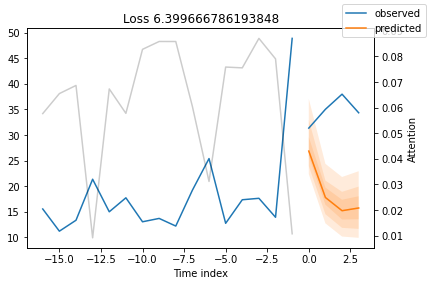

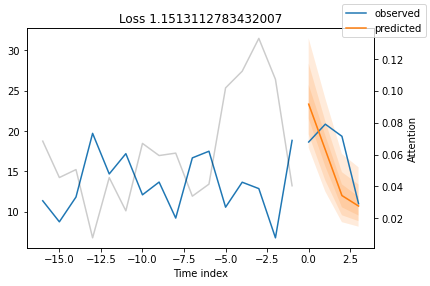

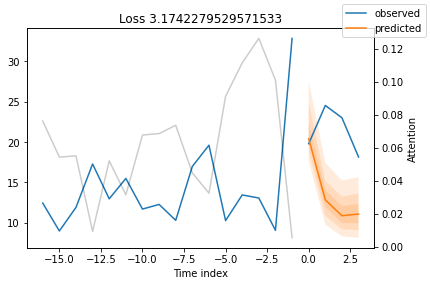

In [61]:
# raw predictions are a dictionary from which all kind of information including quantiles can be extracted
raw_predictions, x = best_tft.predict(val_dataloader, mode="raw", return_x=True)


for idx in range(4):
    best_tft.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True)

{'encoder_length': <Figure size 720x360 with 2 Axes>,
 'pm10_giornaliera_center': <Figure size 720x360 with 2 Axes>,
 'pm10_giornaliera_scale': <Figure size 720x360 with 2 Axes>,
 'time_idx': <Figure size 720x360 with 2 Axes>,
 'relative_time_w': <Figure size 720x360 with 2 Axes>,
 'relative_time_y': <Figure size 720x360 with 2 Axes>,
 'relative_time_m': <Figure size 720x360 with 2 Axes>,
 'relative_time_idx': <Figure size 720x360 with 2 Axes>,
 'azoto_oraria_max': <Figure size 720x360 with 2 Axes>,
 'zolfo_giornaliera': <Figure size 720x360 with 2 Axes>,
 'ozono_8h_max': <Figure size 720x360 with 2 Axes>,
 'pm2dot5_giornaliera': <Figure size 720x360 with 2 Axes>,
 'pm10_giornaliera': <Figure size 720x360 with 2 Axes>,
 'provincia': <Figure size 432x288 with 2 Axes>}

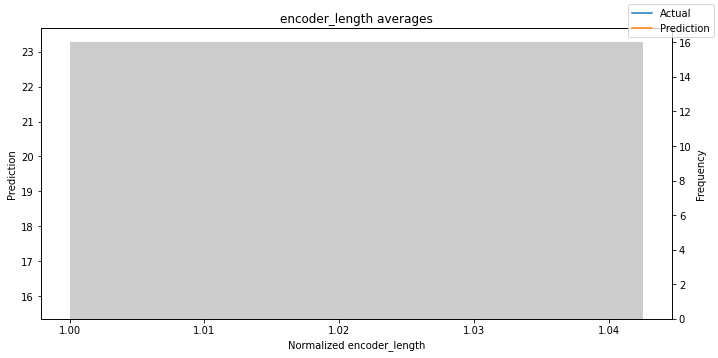

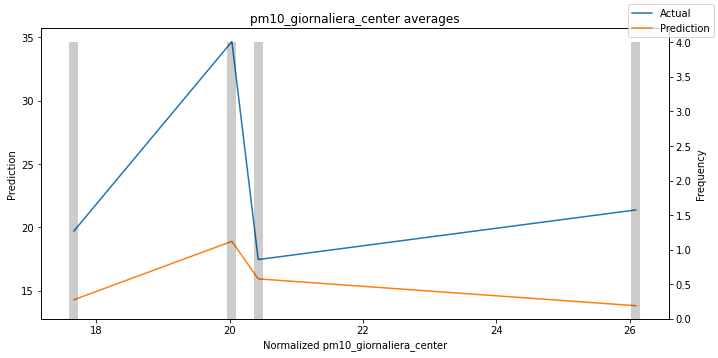

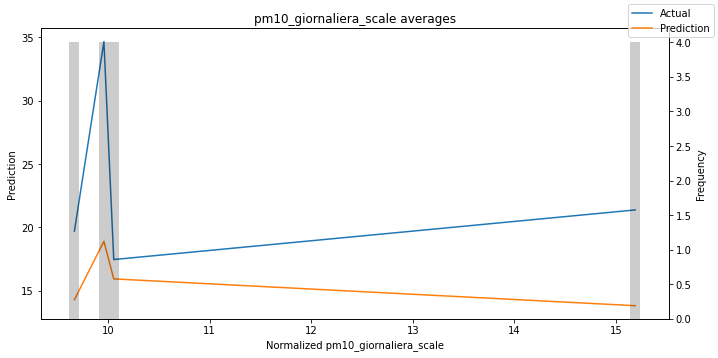

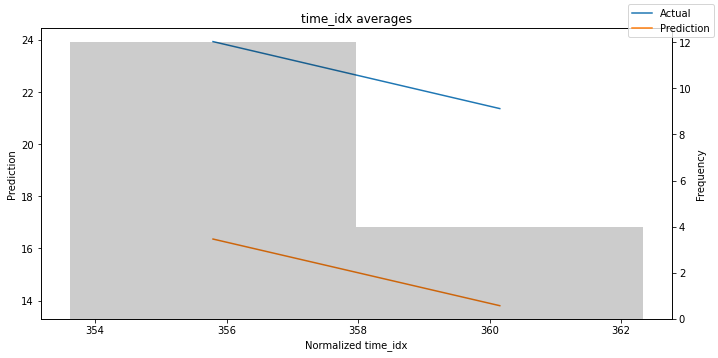

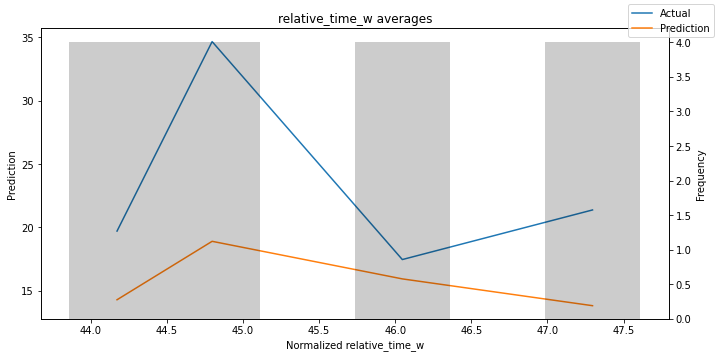

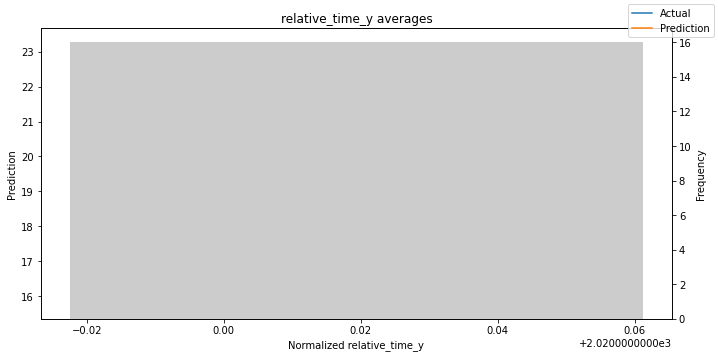

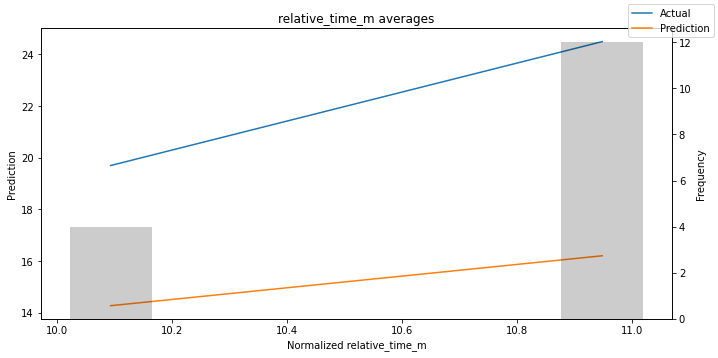

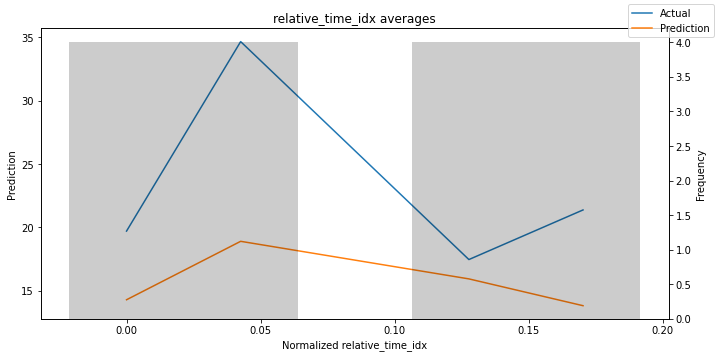

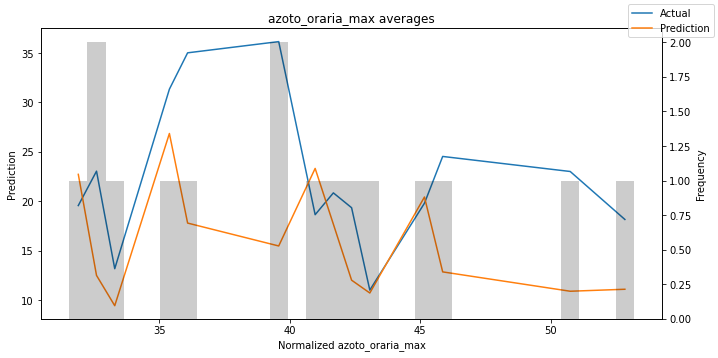

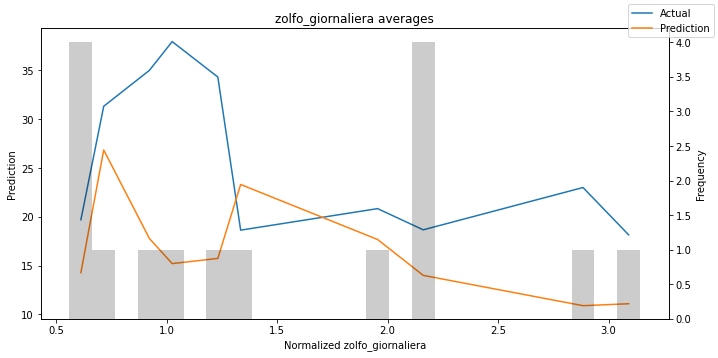

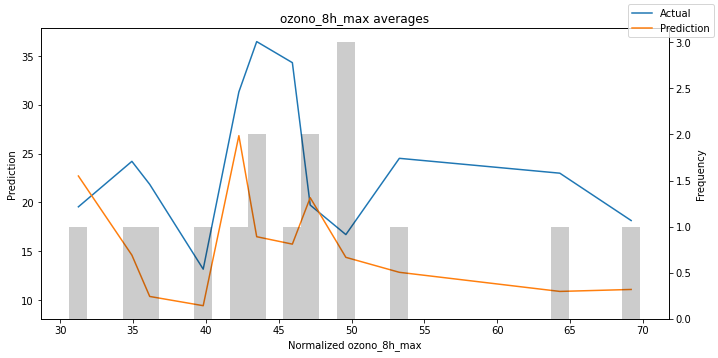

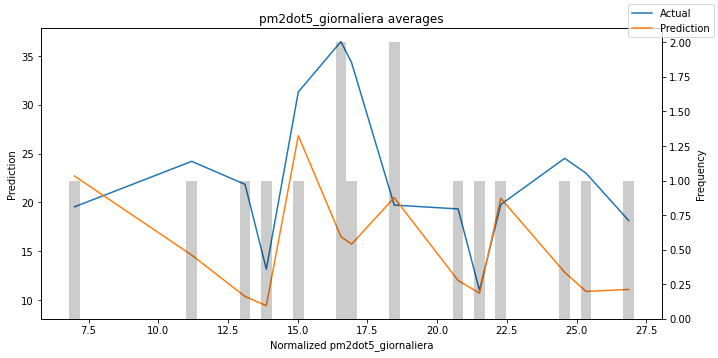

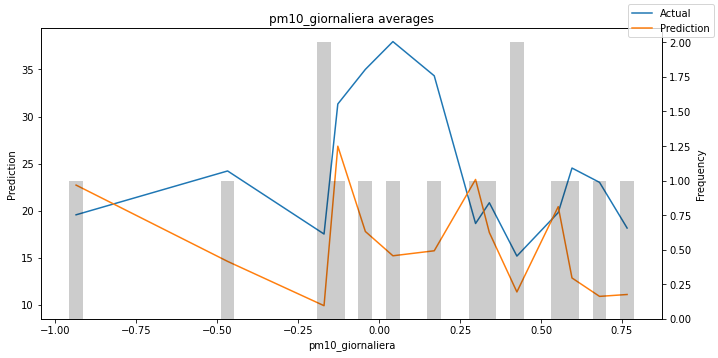

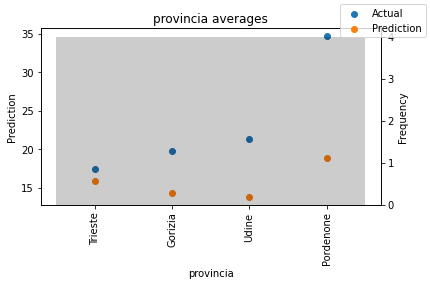

In [62]:
predictions, x = best_tft.predict(val_dataloader, return_x=True)
predictions_vs_actuals = best_tft.calculate_prediction_actual_by_variable(x, predictions)
best_tft.plot_prediction_actual_by_variable(predictions_vs_actuals)

{'attention': <Figure size 432x288 with 1 Axes>,
 'static_variables': <Figure size 504x216 with 1 Axes>,
 'encoder_variables': <Figure size 504x324 with 1 Axes>,
 'decoder_variables': <Figure size 504x234 with 1 Axes>}

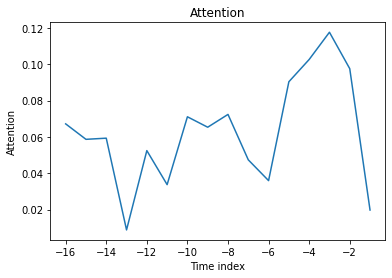

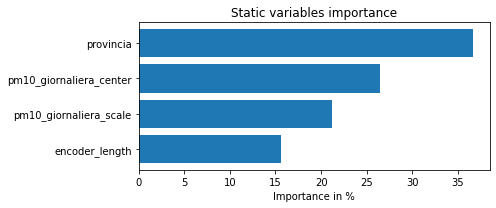

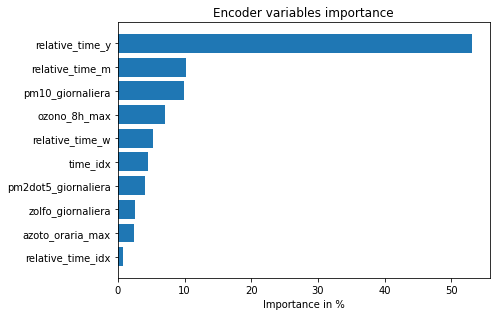

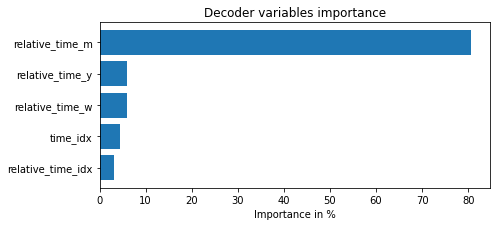

In [63]:
interpretation = best_tft.interpret_output(raw_predictions, reduction="sum")
best_tft.plot_interpretation(interpretation)

## Grafici

In [64]:
import plotly.graph_objects as go

In [65]:
provincia = "Trieste"

raw_prediction, xraw = best_tft.predict(
    training.filter(lambda x: (x.provincia == provincia)),
    mode="prediction",
    return_x=True,
)
baseline_predictions = Baseline().predict(training.filter(lambda x: (x.provincia == provincia)),
    mode="prediction",
    return_x=False)

predicted_df = pd.DataFrame([],columns=["time_idx","values","baseline_values"])
i=0
while i < len(raw_prediction):
    for x in range(0,len(raw_prediction[i])):
        predicted_df = predicted_df.append({"time_idx":xraw["decoder_time_idx"][i][x],"values":raw_prediction[i][x].numpy(),"baseline_values":baseline_predictions[i][x].numpy()},ignore_index=True)
    i += len(raw_prediction[i])
predicted_df["values"] = predicted_df["values"].astype(float)
predicted_df["baseline_values"] = predicted_df["baseline_values"].astype(float)
predicted_df = predicted_df.groupby(by="time_idx").mean().reset_index()
target = df_settimanale[df_settimanale["provincia"]==provincia]
fig = go.Figure()
fig.add_trace(go.Scatter(x=target["time_idx"], y=target["pm10_giornaliera"],mode='lines+markers',name="Realtà"))
fig.add_trace(go.Scatter(x=predicted_df["time_idx"], y=predicted_df["baseline_values"],mode='lines+markers',name="Baseline"))
fig.add_trace(go.Scatter(x=predicted_df["time_idx"], y=predicted_df["values"],mode='lines+markers',name="Predizione"))
fig.show()

In [66]:
provincia = "Trieste"
raw_prediction, xraw = best_tft.predict(
    validation.filter(lambda x: (x.provincia == provincia)),
    mode="prediction",
    return_x=True,
)
predicted_df = pd.DataFrame([],columns=["time_idx","values"])
i=0
while i < len(raw_prediction):
    for x in range(0,len(raw_prediction[i])):
        predicted_df = predicted_df.append({"time_idx":xraw["decoder_time_idx"][i][x],"values":raw_prediction[i][x].numpy()},ignore_index=True)
    i += len(raw_prediction[i])
predicted_df["values"] = predicted_df["values"].astype(float)
target = df_settimanale[df_settimanale["provincia"]==provincia]
fig = go.Figure()
fig.add_trace(go.Scatter(x=target["time_idx"], y=target["pm10_giornaliera"],mode='lines+markers',name="Realtà"))
fig.add_trace(go.Scatter(x=predicted_df["time_idx"], y=predicted_df["values"],mode='lines+markers',name="Predizione"))
fig.show()